<a href="https://colab.research.google.com/github/Jeevesh28/Facility-Location-Problem/blob/main/UFLP%20(with%20and%20without%20Disruptions).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The **Gurobi Optimizer** is an optimization solver for linear programming (LP), quadratic programming (QP), quadratically constrained programming (QCP), mixed-integer linear programming (MILP), mixed-integer quadratic programming (MIQP), and mixed-integer quadratically constrained programming (MIQCP).

In [1]:
%%capture
!pip install gurobipy;

Importing python libraries:

*   **NumPy:** Matrix operations
*   **Matplotlib:** Plotting
*   **Random:** Randomising facility and customer coordinates

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
rnd = np.random
rnd.seed(42) # Change seed value to randomise 

**Initialising Customers and Facility with random coordinates**

In [3]:
n = 20 # Number of Customer
xc = rnd.rand(n) * 200 # x-coordinate
yc = rnd.rand(n) * 100 # y-coordinate

m = 5  # Numebr of Facility
xf = rnd.rand(m) * 200 # x-coordiante 
yf = rnd.rand(m) * 100 # y-coordiante

**Plotting Customers (Blue - Circle) and Facility (Red - Square)**

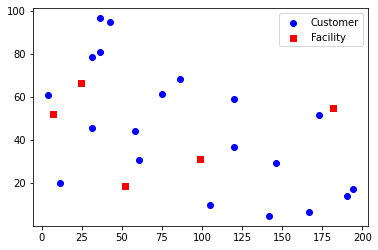

In [4]:
plt.scatter(xc[0:], yc[0:], c='b', label = 'Customer') # Customer
plt.scatter(xf[0:], yf[0:], c='r', marker='s', label = 'Facility') # Facility
plt.legend()
plt.show();

**1. Building the Cost Function for Undisrupted Uncapacitated Facility Location Problem**


In [5]:
I = [i for i in range(0, n)] # Customer
J = [i for i in range(0, m)] # Facility
h = {i: rnd.randint(1, 10) for i in I} # Demand of Customer
A = [(i, j) for i in I for j in J] # 2-D cartesian product
f = {j: 100 for j in J} # Fixed setup cost of Facility
c = {(i, j): 1*np.hypot(xc[i]-xf[j], yc[i]-yf[j]) for (i, j) in A} # Cost to reach customer from Facility

In [6]:
from gurobipy import Model, GRB, quicksum

In [7]:
%%capture
mdl = Model('UFLP');

In [8]:
x = mdl.addVars(J, vtype = GRB.BINARY)
y = mdl.addVars(A, vtype = GRB.CONTINUOUS) 

In [9]:
mdl.ModelSense = GRB.MINIMIZE # Minimisation model
mdl.setObjective(quicksum(f[j]*x[j] for j in J) + quicksum(h[i]*c[i,j]*y[i,j] for i,j in A)) # Cost Function

In [10]:
mdl.addConstrs(quicksum(y[i,j] for j in J) == 1 for i in I);
mdl.addConstrs(y[i,j] <= x[j] for i,j in A);

**Model Optimization**

In [11]:
mdl.optimize() # Solution cost: 3818.43 (varies with changing seed value)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 120 rows, 105 columns and 300 nonzeros
Model fingerprint: 0x08ec4171
Variable types: 100 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+01, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 120 rows, 105 columns, 300 nonzeros
Variable types: 100 continuous, 5 integer (5 binary)

Root relaxation: objective 3.818435e+03, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    3818.4347491 3818.43475  0.00%     -    0s

Explored 0 nodes (8 simplex iterations) in 0.08 seconds
Thread count was 2 (of 2 available processors)

Solution count 1: 3818.43 

Optimal solut

**Customer - Facility mapping**

In [12]:
assignment = [a for a in A if y[a].X > 0.0] 

In [13]:
assignment # (i, j) == (Customer, Facility)

[(0, 1),
 (1, 3),
 (2, 3),
 (3, 1),
 (4, 0),
 (5, 0),
 (6, 2),
 (7, 3),
 (8, 1),
 (9, 1),
 (10, 2),
 (11, 3),
 (12, 3),
 (13, 0),
 (14, 0),
 (15, 0),
 (16, 4),
 (17, 1),
 (18, 1),
 (19, 4)]

**Plotting final obtained map**

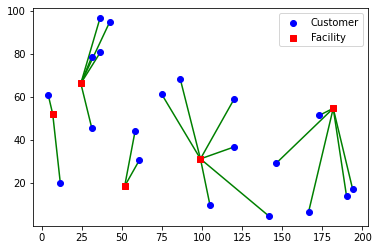

In [14]:
for i, j in assignment:
    plt.plot([xc[i], xf[j]], [yc[i], yf[j]], c='g', zorder=0)
plt.scatter(xc[0:], yc[0:], c='b', label = 'Customer')
plt.scatter(xf[0:], yf[0:], c='r',marker='s', label = 'Facility')
plt.legend()
plt.show();

**2. Building the Cost Function for Disrupted Uncapacitated Facility Location Problem**

In [15]:
max_disruption = 10000 # High penalty for disrupted facility
I = [i for i in range(0, n)] # Customer
J = [i for i in range(0, m)] # Facility
h = {i: rnd.randint(1, 10) for i in I} # Demand of Customer
A = [(i, j) for i in I for j in J] # 2-D cartesian product
f = {j: 100 for j in J} # Fixed setup cost of Facility
c = {(i, j): 1*np.hypot(xc[i]-xf[j], yc[i]-yf[j]) for (i, j) in A} # Cost to reach customer from Facility
p = {j: rnd.choice(np.array((0, max_disruption // 4, max_disruption // 2, max_disruption)), p=[0.5, 0.25, 0.15, 0.1]) for j in J} # Penalty due to disruptions

In [16]:
p # Penalty to Facility (Although used particular fixed values, any probability distribution function can be used instead)

{0: 2500, 1: 0, 2: 2500, 3: 0, 4: 10000}

In [17]:
%%capture
mdl = Model('UFLP');

In [18]:
x = mdl.addVars(J, vtype = GRB.BINARY)
y = mdl.addVars(A, vtype = GRB.CONTINUOUS)

In [19]:
mdl.ModelSense = GRB.MINIMIZE # Minimization model
mdl.setObjective(quicksum(f[j]*x[j] for j in J) + quicksum(h[i]*c[i,j]*y[i,j] for i,j in A) + quicksum(p[j]*x[j] for j in J)) # Cost Function

In [20]:
mdl.addConstrs(quicksum(y[i,j] for j in J) == 1 for i in I);
mdl.addConstrs(y[i,j] <= x[j] for i,j in A);

**Model Optimization**

In [21]:
mdl.optimize() # Solution cost: 5180.93 (varies with changing seed value)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 120 rows, 105 columns and 300 nonzeros
Model fingerprint: 0xbe58d5d7
Variable types: 100 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+01, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 120 rows, 105 columns, 300 nonzeros
Variable types: 100 continuous, 5 integer (5 binary)

Root relaxation: objective 5.180927e+03, 27 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    5180.9265793 5180.92658  0.00%     -    0s

Explored 0 nodes (27 simplex iterations) in 0.05 seconds
Thread count was 2 (of 2 available processors)

Solution count 1: 5180.93 

Optimal sol

**Customer - Facility mapping**

In [22]:
assignment = [a for a in A if y[a].X > 0.0] 

In [23]:
assignment # (i, j) == (Customer, Facility)

[(0, 1),
 (1, 3),
 (2, 3),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 3),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 3),
 (12, 3),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1)]

**Plotting final obtained map**

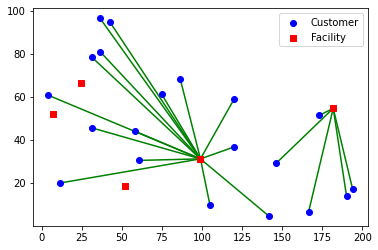

In [24]:
for i, j in assignment:
    plt.plot([xc[i], xf[j]], [yc[i], yf[j]], c='g', zorder=0)
plt.scatter(xc[0:], yc[0:], c='b', label = 'Customer')
plt.scatter(xf[0:], yf[0:], c='r',marker='s', label = 'Facility')
plt.legend()
plt.show();